## ARIMA Model Time Series Forecasting

In [1]:
#import packages
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
#read Data
data=pd.read_csv('BOE.csv',index_col='Date',parse_dates=True)
data.head()

,Value
Date,
2017-09-28,0.8485
2017-09-27,0.8524
2017-09-26,0.8498
2017-09-25,0.8428
2017-09-22,0.8356


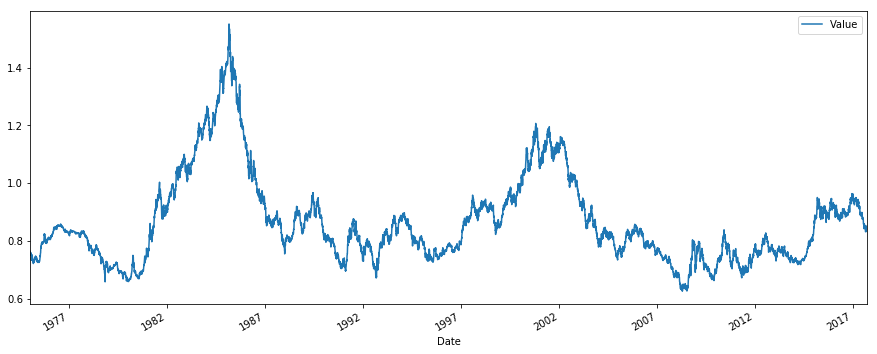

In [3]:
#linear Plot
data.plot()
pyplot.show()

In [4]:
ts=data['Value']
ts.head()

Date
2017-09-28    0.8485
2017-09-27    0.8524
2017-09-26    0.8498
2017-09-25    0.8428
2017-09-22    0.8356
Name: Value, dtype: float64

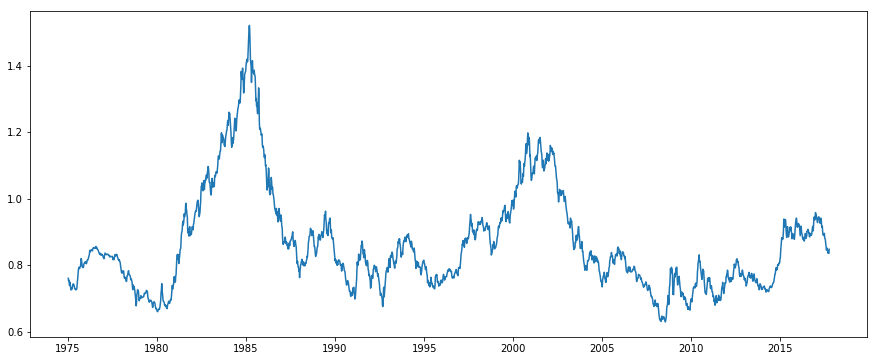

In [5]:
#Resampling the data by week
ts_week=ts.resample('W').mean()
plt.plot(ts_week)

In [6]:
#Checking stationarity with dicky-fuller test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

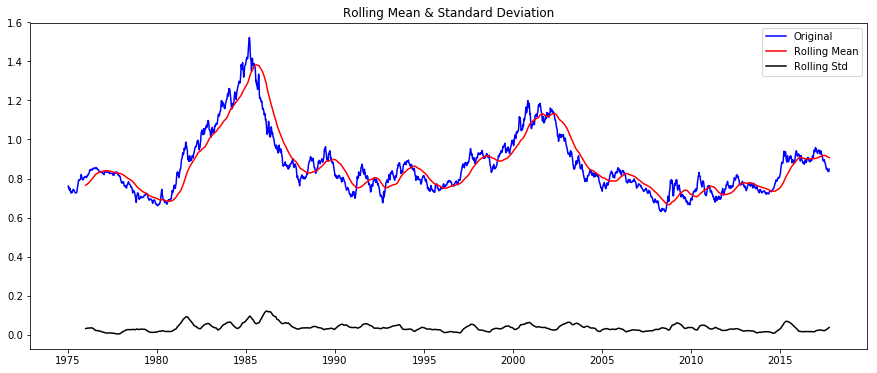

Results of Dickey-Fuller Test:
Test Statistic                   -2.072905
p-value                           0.255548
#Lags Used                        2.000000
Number of Observations Used    2228.000000
Critical Value (1%)              -3.433288
Critical Value (5%)              -2.862838
Critical Value (10%)             -2.567461
dtype: float64


In [7]:
test_stationarity(ts_week)

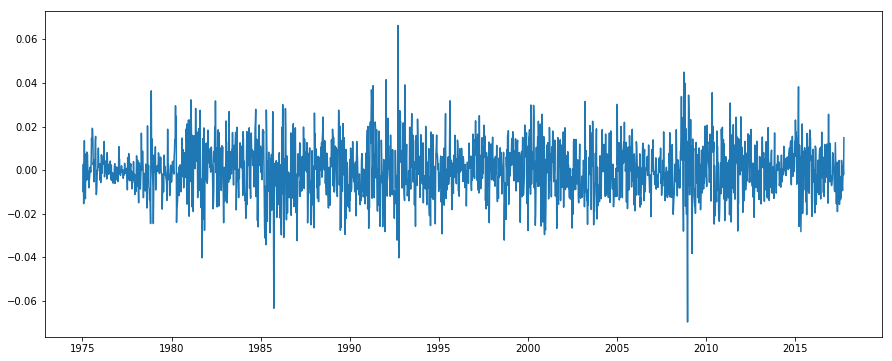

In [13]:
# Applying differentiation to gain stationarity
ts_week_log = np.log(ts_week)

ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

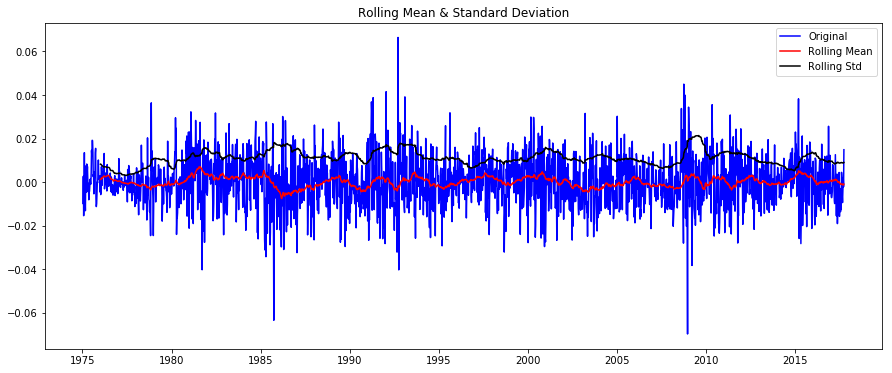

Results of Dickey-Fuller Test:
Test Statistic                  -36.529383
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2229.000000
Critical Value (1%)              -3.433287
Critical Value (5%)              -2.862838
Critical Value (10%)             -2.567461
dtype: float64


In [14]:
#Again check for stationarity
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

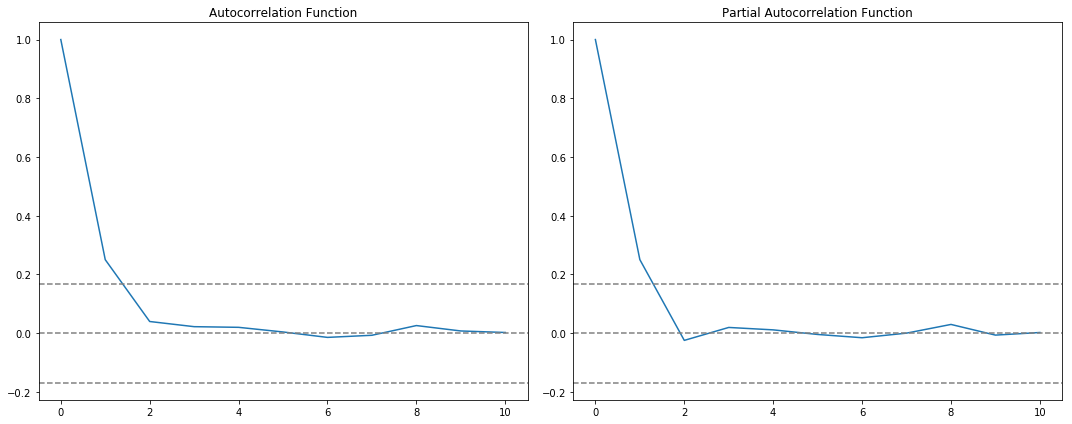

In [15]:
# Generating p,q values from PACF and ACF

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



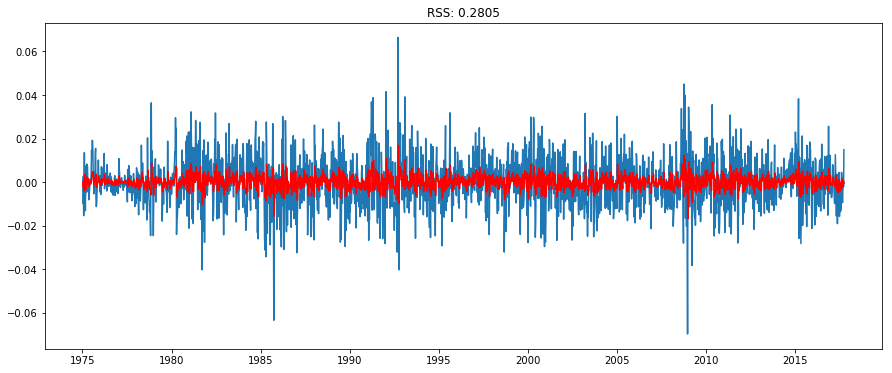

In [16]:
'''
We will take values of q from ACF plot, where the lag value crosses the upper confidence level which 1 in our case.
We will take values of p from PACF where lag value drops off 0 for first time, by seeing graph we can see p values is 2.
d=1 as we differentiated once
So model parameters for our ARIMA model are (2,1,1).
'''
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

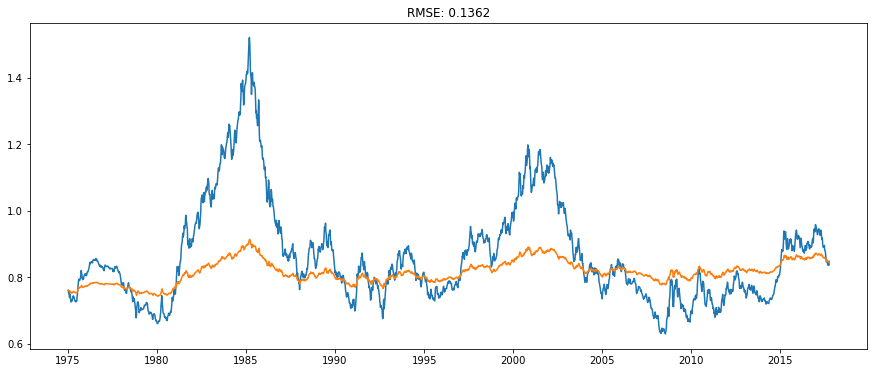

In [17]:
#Measuring Root Mean Square Error and plot the  orginal series as well as predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [18]:
#divding the series into train data and test data. appy the built ARIMA model and get prediction values with Mean Square Error
size = int(len(ts_week_log) - 10)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=0.861351, expected=0.856980
predicted=0.855459, expected=0.846240
predicted=0.843628, expected=0.850020
predicted=0.851299, expected=0.851780
predicted=0.852062, expected=0.846460
predicted=0.845147, expected=0.838525
predicted=0.836666, expected=0.836180
predicted=0.835781, expected=0.837640
predicted=0.838050, expected=0.835860
predicted=0.835384, expected=0.848375


Printing Mean Squared Error of Predictions...
Test MSE: 0.000056


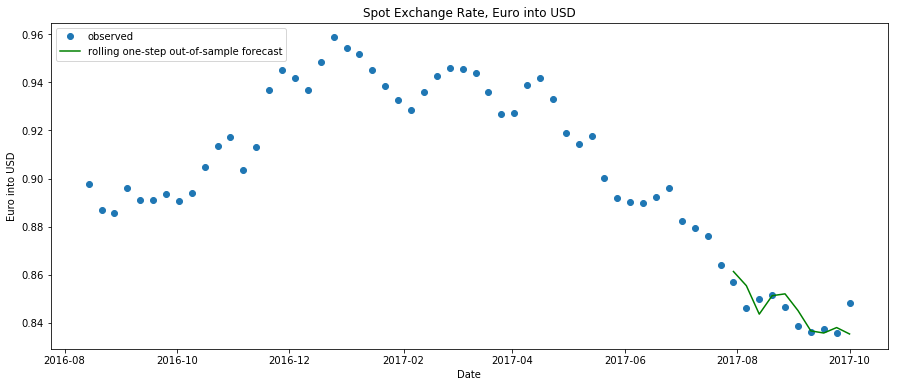

In [19]:
#plot the test data as well as predicted data 
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')